# Experimentación

## Preliminares

In [4]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home/schuster/.virtualenvs/metodos/bin/python (found version "3.6.9") 
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.6m.so
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/schuster/Documents/Facultad/Metodos/metodos-tp2
-- Conf

In [1]:
from tqdm import tqdm
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import metnum
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

## Exploración de datos y pruebas

### Distribución de los datos

In [7]:
data = pd.read_csv("../data/train.csv")
data = data["label"].value_counts(normalize=True)
data = data.to_frame()
print(data.to_latex())

\begin{tabular}{lr}
\toprule
{} &     label \\
\midrule
1 &  0.111524 \\
7 &  0.104786 \\
3 &  0.103595 \\
9 &  0.099714 \\
2 &  0.099452 \\
6 &  0.098500 \\
0 &  0.098381 \\
4 &  0.096952 \\
8 &  0.096738 \\
5 &  0.090357 \\
\bottomrule
\end{tabular}



### Analizando valores de $\alpha$
Veamos qué sucede cuando variamos alpha para distintos tamaños de matriz de entrenamiento. Para ellos analizaremos cuántas componentes principales conviene tomar observando la fracción de la varianza que posee un conjunto de componentes principales respecto del total.

In [2]:
partitions = [10,50,100,500,1000,5000,10000,20000,42000]

def proporcionAlpha():
    data = pd.read_csv("../data/train.csv")
    df_alpha = pd.DataFrame(columns = ['alpha', 'size'])
    for split in tqdm(partitions):
        part = data[:split]
        train = part[part.columns[1:]].values
        alphas = min(split,784)
        pca = metnum.PCA(alphas)
        autoval = pca.get_eigenvaluesMatrix(train)
        total = sum(autoval)
        for alpha in range(1,alphas):
            lparcial = autoval[:alpha]
            parcial = sum(lparcial)
            parcial = parcial/total
            if parcial > 0.95:
                df_alpha = pd.concat([df_alpha, pd.DataFrame([[alpha, split]], columns=['alpha', 'size'])])
                ax = df_alpha.plot.bar(x='size', y='alpha', rot=0)
                figb = ax.get_figure()
                figb.savefig("barAlpha.png")
                
                fig, axs = plt.subplots(1, 1, figsize=(10, 10))
                sns_plt = sns.scatterplot(data=df_alpha, x='size', y='alpha', s=200)
                figure = sns_plt.get_figure()
                figure.savefig('alphas.png') 
                ax = df_alpha.plot.bar(x='size', y='alpha', rot=0)
                print(df_alpha)

                break
                
    ax = df_alpha.plot.bar(x='size', y='alpha', rot=0)
    fig, axs = plt.subplots(1, 1, figsize=(10, 10))
    sns.scatterplot(data=df_alpha, x='size', y='alpha', s=200)
    print(df_alpha)
    return


def alphaKFijo():
    data = pd.read_csv("../data/train.csv")
    data = data[:5000]
    
    X = data[data.columns[1:]].values
    y = data["label"].values.reshape(-1, 1)

    limit = int(0.8 * X.shape[0]) 
    train, trainLabel = X[:limit], y[:limit]
    test, testLabel = X[limit:], y[limit:]

    pca = metnum.PCA(40)
    V = pca.get_eigenvectorMatrix(train)

    accs = []
    for alpha in range(1, 40, 2):  
        trainPCA = train @ V[:, :alpha]
        testPCA = test @ V[:, :alpha]

        clf = metnum.KNNClassifier(10)
        clf.fit(trainPCA, trainLabel)

        testPred = clf.predict(testPCA)

        acc = accuracy_score(testLabel, testPred)
        accs.append(acc)

    plt.plot(alphaRange, accs, 'g-o')
    plt.xlabel("Alpha")
    plt.ylabel("Accuracy")
    plt.title("Performance por alpha");
    return


 11%|█         | 1/9 [00:00<00:06,  1.25it/s]

  alpha size
0     8   10


 22%|██▏       | 2/9 [00:07<00:17,  2.50s/it]

  alpha size
0     8   10
0    29   50


 33%|███▎      | 3/9 [00:32<00:55,  9.32s/it]

  alpha size
0     8   10
0    29   50
0    47  100


 44%|████▍     | 4/9 [04:29<06:28, 77.70s/it]

  alpha size
0     8   10
0    29   50
0    47  100
0    82  500


 56%|█████▌    | 5/9 [17:27<19:10, 287.74s/it]

  alpha  size
0     8    10
0    29    50
0    47   100
0    82   500
0    91  1000


 67%|██████▋   | 6/9 [29:48<21:11, 423.67s/it]

  alpha  size
0     8    10
0    29    50
0    47   100
0    82   500
0    91  1000
0   100  5000


/home/schuster/.virtualenvs/metodos/lib/python3.6/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
 78%|███████▊  | 7/9 [41:31<16:54, 507.50s/it]

  alpha   size
0     8     10
0    29     50
0    47    100
0    82    500
0    91   1000
0   100   5000
0   101  10000


/home/schuster/.virtualenvs/metodos/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 89%|████████▉ | 8/9 [52:51<09:19, 559.33s/it]

  alpha   size
0     8     10
0    29     50
0    47    100
0    82    500
0    91   1000
0   100   5000
0   101  10000
0   102  20000


100%|██████████| 9/9 [1:03:51<00:00, 425.71s/it]

  alpha   size
0     8     10
0    29     50
0    47    100
0    82    500
0    91   1000
0   100   5000
0   101  10000
0   102  20000
0   102  42000
  alpha   size
0     8     10
0    29     50
0    47    100
0    82    500
0    91   1000
0   100   5000
0   101  10000
0   102  20000
0   102  42000



/home/schuster/.virtualenvs/metodos/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


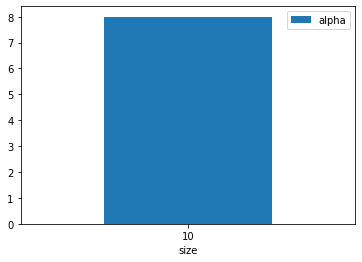

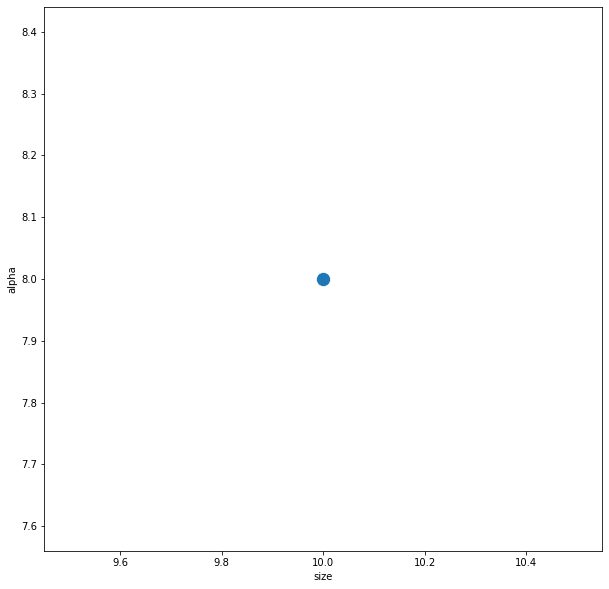

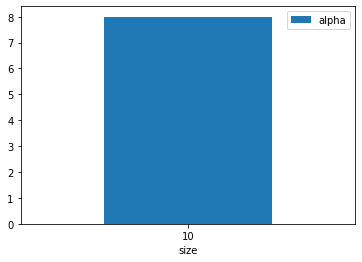

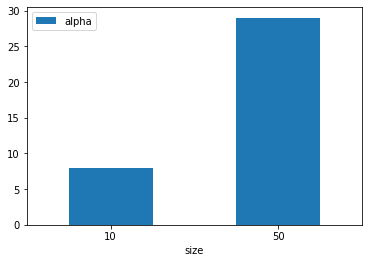

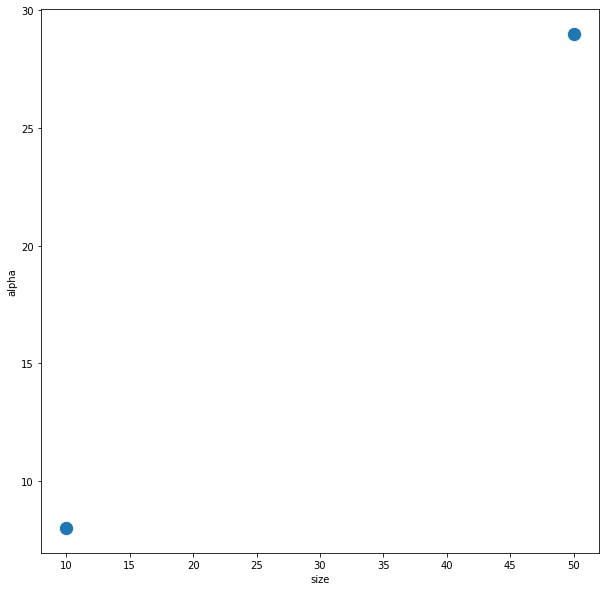

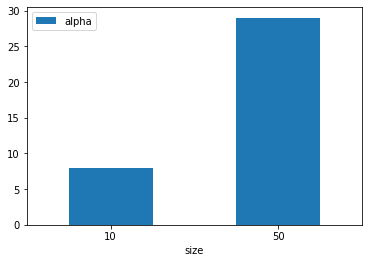

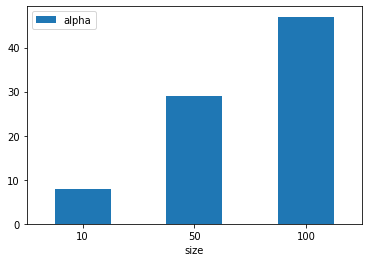

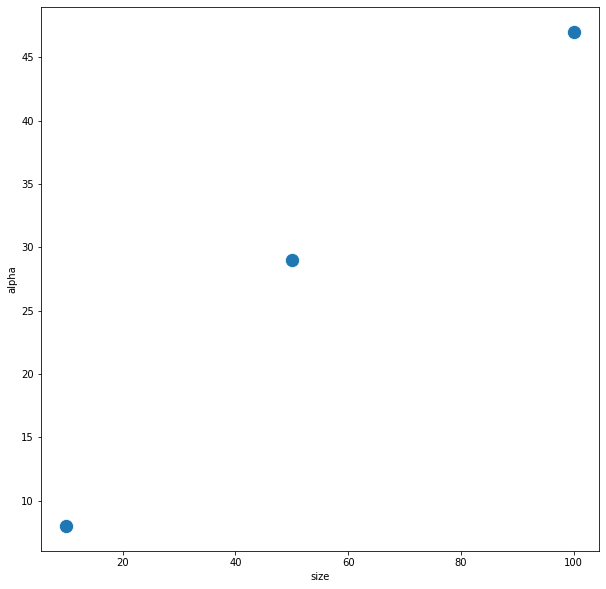

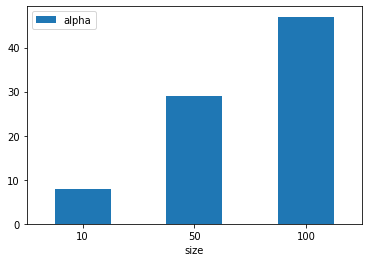

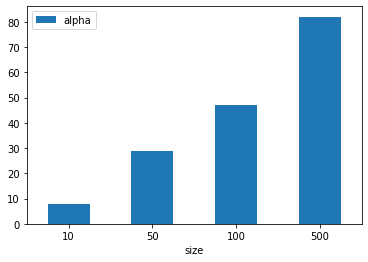

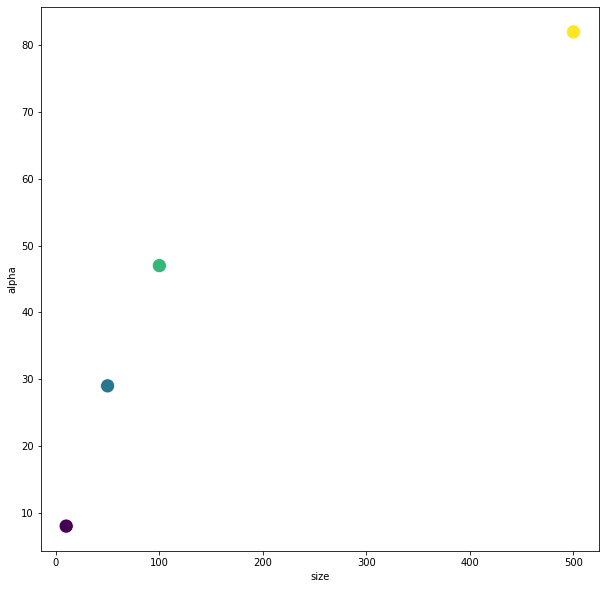

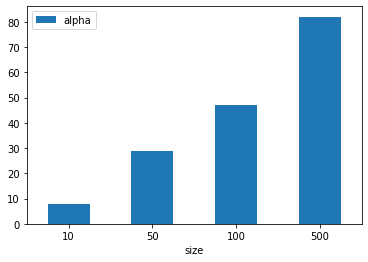

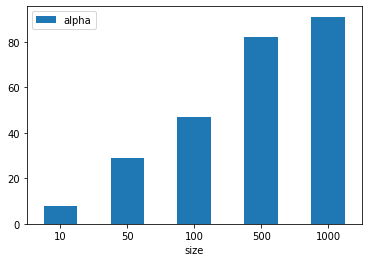

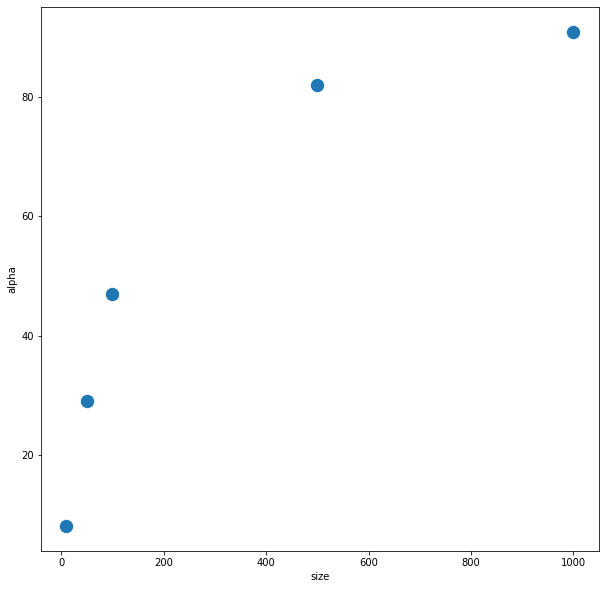

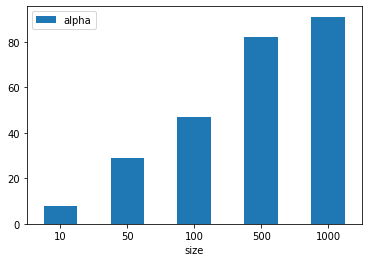

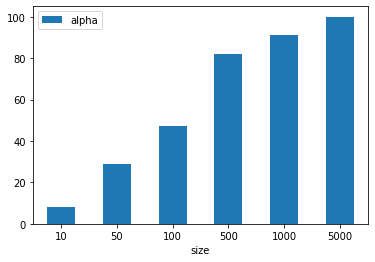

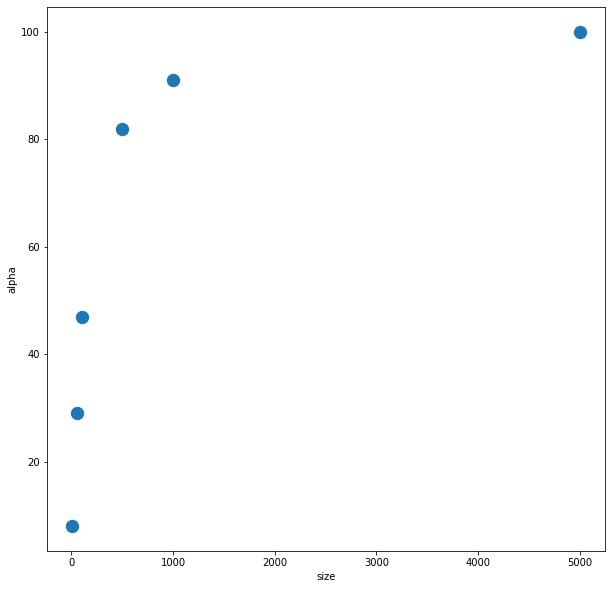

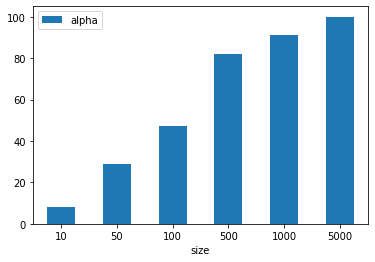

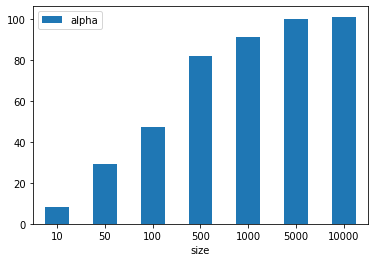

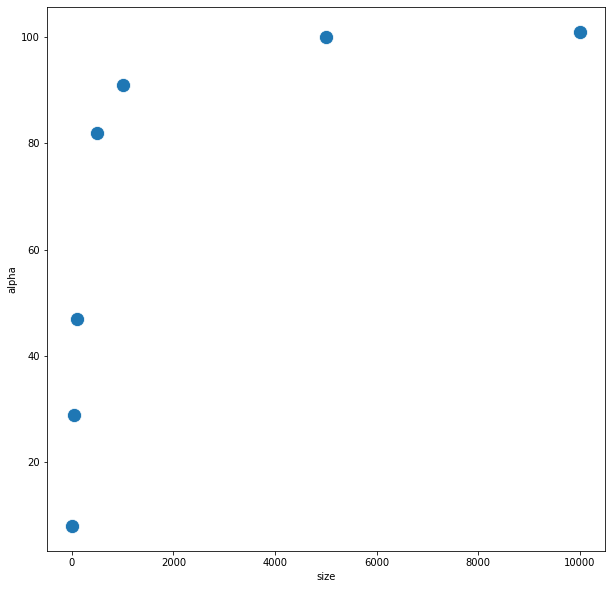

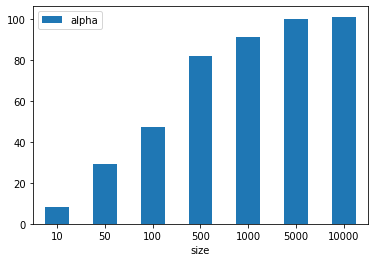

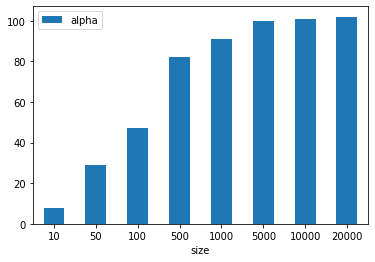

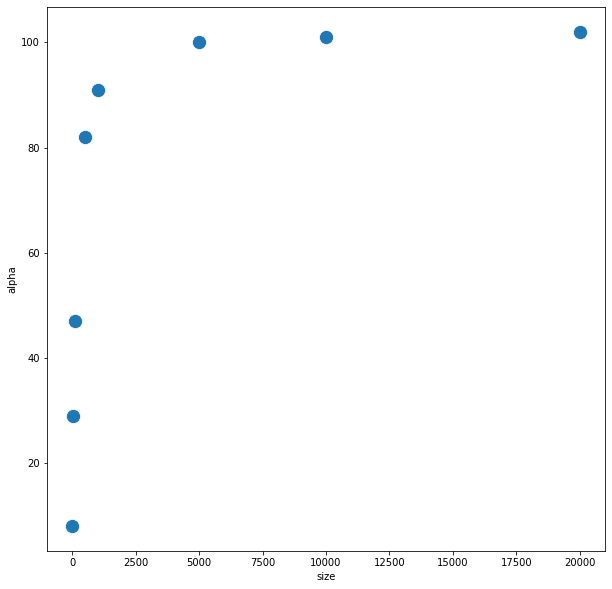

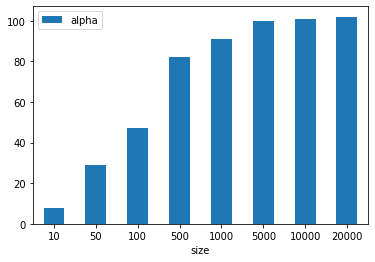

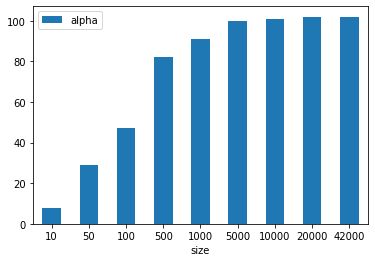

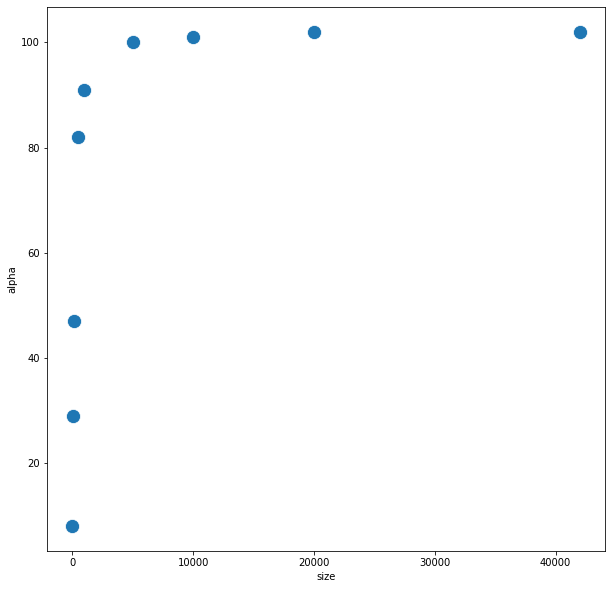

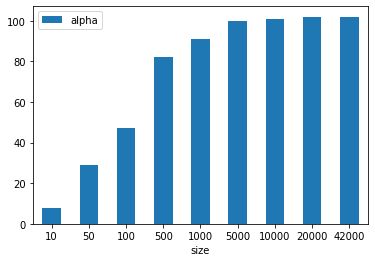

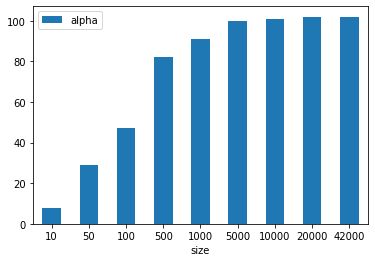

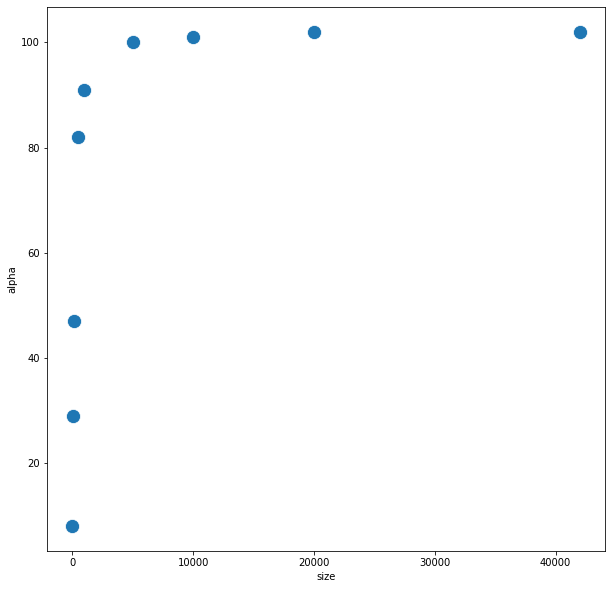

In [3]:
proporcionAlpha()

### Analizando k y $\alpha$
Analizamos cómo varía el accuracy cuando se varía k y alpha en rangos pequeños.

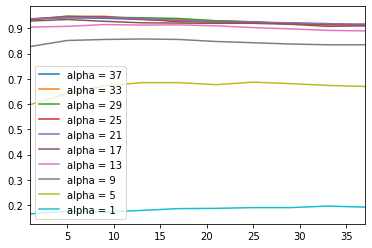

In [7]:
kRange = list(range(1, 40, 4))
alphaRange = list(range(1, 40, 4))

#Preparo los datos
data = data[:5000]
X = data[data.columns[1:]].values
y = data["label"].values.reshape(-1, 1)

limit = int(0.8 * X.shape[0]) 
train, trainLabel = X[:limit], y[:limit]
test, testLabel = X[limit:], y[limit:]

pca = metnum.PCA(alphaRange[-1])
V = pca.get_eigenvectorMatrix(train)

df = pd.DataFrame(index = kRange)
df2 = pd.DataFrame(columns = ['k', 'alpha', 'acc'])
for alpha in alphaRange: 
    accs = []
    for k in kRange:
        trainPCA = train @ V[:, :alpha]
        testPCA = test @ V[:, :alpha]

        clf = metnum.KNNClassifier(k)
        #clf = KNeighborsClassifier(k)
        clf.fit(trainPCA, trainLabel)

        testPred = clf.predict(testPCA)
        acc = accuracy_score(testLabel, testPred)
        accs.append(acc)
        df2 = pd.concat([df2, pd.DataFrame([[k, alpha, acc]], columns=['k', 'alpha', 'acc'])])
        
    df.insert(0,"alpha = " + str(alpha),accs)
    #df = pd.concat([df, pd.DataFrame([accs + [str(alpha)]], columns=col)])  
df.plot();

## Experimentos

### Experimento 1:
KNN con o sin PCA: Hacer un heatmap de calidad de resultados y tiempo de ejecución para KNN con y sin PCA por separado. Una vez que contemos con esos valores, podemos empezar a establecer relaciones entre ambos métodos, pudiendo realizar un cociente entre calidad/tiempo y entre distintos resultados de con/sin PCA.

In [2]:
alphaRange = list(range(5,105,5))
kRange = [1] + list(range(5,55,5))
splits = [2,5,10]

colsPCA = ['Fold', 'Alpha' , 'k', 'Accuracy', 'Time', 'Kappa', 'Recall', 'F1 Score']
colsNoPCA = ['Fold', 'k', 'Accuracy', 'Time', 'Kappa', 'Recall', 'F1 Score']

rawData = pd.read_csv("../data/train.csv")

def experimento1():
    tiempoInicio = time.clock()
    dfPCA = pd.DataFrame(columns = colsPCA)
    dfNoPCA = pd.DataFrame(columns = colsNoPCA)
    
    for split in tqdm(splits):
        tiempoInicioSplit = time.clock()
        kf = KFold(n_splits=split)
        dfFoldPCA = pd.DataFrame(columns = colsPCA)
        dfFoldNoPCA = pd.DataFrame(columns = colsNoPCA)
        
        for train, test in kf.split(rawData):
            dataPCA = calcularPCA(train, test, split)
            dataNoPCA = calcularNoPCA(train, test, split)
            
            dfFoldNoPCA = pd.concat([dfFoldNoPCA, dataNoPCA])
            dfFoldPCA = pd.concat([dfFoldPCA, dataPCA])
            
        dfFoldPCA = dfFoldPCA.groupby(['Fold', 'Alpha', 'k']).mean().reset_index()
        dfFoldNoPCA = dfFoldNoPCA.groupby(['Fold', 'k']).mean().reset_index()

        dfPCA = pd.concat([dfPCA, dfFoldPCA])        
        dfNoPCA = pd.concat([dfNoPCA, dfFoldNoPCA])
        
        pd.DataFrame(dfPCA).to_csv('results/exp1/PCA.csv')
        pd.DataFrame(dfNoPCA).to_csv('results/exp1/noPCA.csv')
        
        tiempoFinalSplit = time.clock()
        print('El split se ejecutó durante ' + str((tiempoFinalSplit - tiempoInicioSplit)/3600) + ' horas')
    tiempoFinal = time.clock()
    print('El experimento se ejecutó durante '+str((tiempoFinal - tiempoInicio)/3600)+' horas')
    return  
        

    
def calcularPCA(train, test, fold):
    df = pd.DataFrame(columns = colsPCA)

    rawTrain, labelTrain = rawData.loc[train, rawData.columns[1:]].values, rawData.loc[train, "label"].values.reshape(-1, 1)
    rawTest, labelTest = rawData.loc[test, rawData.columns[1:]].values, rawData.loc[test, "label"].values.reshape(-1, 1)
    
    #Sumar al costo temporal el de calcular el alpha por separado (aproximado)
    pca = metnum.PCA(alphaRange[-1])
    V = pca.get_eigenvectorMatrix(rawTrain)  
    
    for alpha in alphaRange:
        W = V[:, :alpha]
        dataTrain = rawTrain @ W
        dataTest = rawTest @ W

        for k in kRange:
            clf = metnum.KNNClassifier(k)
            clf.fit(dataTrain, labelTrain)
            
            t0 = time.clock()
            predTest = clf.predict(dataTest)
            t1 = time.clock() - t0 #segundos
            
            acc = accuracy_score(labelTest, predTest)
            kappa = cohen_kappa_score(labelTest, predTest) # El orden da igual porque es simétrica.
            recall = recall_score(labelTest, predTest, average='weighted') # No es simetrico
            f1 = f1_score(labelTest, predTest, average='weighted') # No es simetrico
            
            dfdata = {'Fold': fold, 'Alpha': alpha, 'k': k, 'Accuracy': acc, 'Time': t1*1000, 'Kappa': kappa, 'Recall': recall, 'F1 Score': f1}
            df = df.append(dfdata, ignore_index=True)
    
    return df




def calcularNoPCA(train, test, fold):
    df = pd.DataFrame(columns = colsNoPCA)

    dataTrain, labelTrain = rawData.loc[train, rawData.columns[1:]].values, rawData.loc[train, "label"].values.reshape(-1, 1)
    dataTest, labelTest = rawData.loc[test, rawData.columns[1:]].values, rawData.loc[test, "label"].values.reshape(-1, 1)

    for k in kRange:
        clf = metnum.KNNClassifier(k)
        clf.fit(dataTrain, labelTrain)

        t0 = time.clock()
        predTest = clf.predict(dataTest)
        t1 = time.clock() - t0 #segundos

        acc = accuracy_score(labelTest, predTest)
        kappa = cohen_kappa_score(labelTest, predTest) # El orden da igual porque es simétrica.
        recall = recall_score(labelTest, predTest, average='weighted') # No es simetrico
        f1 = f1_score(labelTest, predTest, average='weighted') # No es simetrico

        dfdata = {'Fold': fold, 'k': k, 'Accuracy': acc, 'Time': t1*1000, 'Kappa': kappa, 'Recall': recall, 'F1 Score': f1}
        df = df.append(dfdata, ignore_index=True)
        
    return df


In [ ]:
experimento1()

 33%|███▎      | 1/3 [3:17:22<6:34:44, 11842.08s/it]

El split se ejecutó durante 3.311369565 horas


 67%|██████▋   | 2/3 [11:29:37<4:45:50, 17150.11s/it]

El split se ejecutó durante 5.469727128333333 horas


### Experimento 2:
KNN con PCA: vamos a partir en diferentes tamaños

In [52]:
getAlpha = {
    50: 25,
    100: 50,
    200: 70,
    500: 80,
    1000: 90,
    2000: 90,
    5000: 100,
    10000: 100,
    20000: 100,
    42000: 100
}
getK = {
    50: 1,
    100: 1,
    200: 2,
    500: 5,
    1000: 8,
    2000: 8,
    5000: 8,
    10000: 9,
    20000: 10,
    42000: 10
}
tamanos = [100,200,500,1000,2000,5000,10000,20000,42000]
splits = [2,5,10]
cols = ['Size', 'Fold', 'k', 'Accuracy', 'Time', 'Kappa', 'Recall', 'F1 Score']

def experimento2():
    rawData = pd.read_csv("../data/train.csv")
    df = pd.DataFrame(columns = cols)
    
    for tam in tqdm(tamanos):
        data = rawData[:tam]
        
        for split in splits:
            kf = KFold(n_splits=split)
            dfFold = pd.DataFrame(columns = cols)
            
            for train, test in kf.split(data):

                dataTrain, labelTrain = data.loc[train, data.columns[1:]].values, data.loc[train, "label"].values.reshape(-1, 1)
                dataTest, labelTest = data.loc[test, data.columns[1:]].values, data.loc[test, "label"].values.reshape(-1, 1)

                pca = metnum.PCA(getAlpha[tam])
                pca.fit(dataTrain)
                dataTrain = pca.transform(dataTrain)
                dataTest = pca.transform(dataTest)

                dfSplit = calcular(dataTrain, labelTrain, dataTest, labelTest, split, tam)
                
                dfFold = dfFold.append(dfSplit, ignore_index=True)

            dfFold.groupby(['Fold', 'Size', 'k']).mean().reset_index()
            df = pd.concat([df, dfFold])
            pd.DataFrame(df).to_csv('results/exp2/data.csv')

    pd.DataFrame(df).to_csv('results/exp2/data.csv')
    print(df)
    return  
        

def calcular(dataTrain, labelTrain, dataTest, labelTest, fold, size):
    
    k = getK[size]
    
    clf = metnum.KNNClassifier(k)
    clf.fit(dataTrain, labelTrain)
    
    t0 = time.clock()
    predTest = clf.predict(dataTest)
    t1 = time.clock() - t0 #segundos

    acc = accuracy_score(labelTest, predTest)
    kappa = cohen_kappa_score(labelTest, predTest) # El orden da igual porque es simétrica.
    recall = recall_score(labelTest, predTest, average='weighted') # No es simetrico
    f1 = f1_score(labelTest, predTest, average='weighted') # No es simetrico

    dfdata = {'Size': size, 'Fold': fold, 'k': k, 'Accuracy': acc, 'Time': t1*1000, 'Kappa': kappa, 'Recall': recall, 'F1 Score': f1}
    
    return dfdata

In [53]:
experimento2()

100%|██████████| 9/9 [25:40<00:00, 171.21s/it]

       Size  Fold     k  Accuracy       Time     Kappa    Recall  F1 Score
0     100.0   2.0   1.0  0.680000      0.082  0.638336  0.680000  0.675104
1     100.0   2.0   1.0  0.560000      0.078  0.503610  0.560000  0.556837
0     100.0   5.0   1.0  0.700000      0.093  0.657143  0.700000  0.716429
1     100.0   5.0   1.0  0.900000      0.051  0.886364  0.900000  0.904762
2     100.0   5.0   1.0  0.650000      0.091  0.602273  0.650000  0.620000
3     100.0   5.0   1.0  0.500000      0.052  0.411765  0.500000  0.495000
4     100.0   5.0   1.0  0.500000      0.052  0.445983  0.500000  0.540833
0     100.0  10.0   1.0  0.600000      0.055  0.540230  0.600000  0.673333
1     100.0  10.0   1.0  0.800000      0.036  0.770115  0.800000  0.766667
2     100.0  10.0   1.0  0.900000      0.056  0.882353  0.900000  0.900000
3     100.0  10.0   1.0  0.800000      0.036  0.759036  0.800000  0.833333
4     100.0  10.0   1.0  0.600000      0.057  0.534884  0.600000  0.640000
5     100.0  10.0   1.0  

### Experimento 3:
En el caso de tener k=1 se asigna la etiqueta del elemento más cercano del conjunto de entrenamiento y si k=N, voy a asignar la etiqueta mayoritaria en el conjunto de entrenamiento.
Tomar una muestra, fijar un alpha y ver qué sucede con el accuracy a medida que se crece el k. Se espera que suceda lo antes explicado.

In [121]:
alphaExp3 = 100
splits = [2,5,10,20]
size = 42000

def getK(i):
    return int(i + 1.2**i)

def experimento3():
    data = pd.read_csv("../data/train.csv")
    df = pd.DataFrame(columns = ['Fold','k','Accuracy','Time','Kappa', 'Recall', 'F1 Score'])

    for split in tqdm(splits):
        kf = KFold(n_splits=split)
        
        for train, test in kf.split(data):
            dataTrain, labelTrain = data.loc[train, data.columns[1:]].values, data.loc[train, "label"].values.reshape(-1, 1)
            dataTest, labelTest = data.loc[test, data.columns[1:]].values, data.loc[test, "label"].values.reshape(-1, 1)

            pca = metnum.PCA(alphaExp3)
            pca.fit(dataTrain)
            dataTrain = pca.transform(dataTrain)
            dataTest = pca.transform(dataTest)
            
            size = train.shape[0]
            
            i = 0
            k = getK(i)
            while(k < size):
                clf = metnum.KNNClassifier(k)
                clf.fit(dataTrain, labelTrain)
                
                t0 = time.clock()
                predTest = clf.predict(dataTest)
                t1 = time.clock() - t0 #milisegundos
                
                acc = accuracy_score(labelTest, predTest)
                kappa = cohen_kappa_score(labelTest, predTest) # El orden da igual porque es simétrica.
                recall = recall_score(labelTest, predTest, average='weighted') # No es simetrico
                f1 = f1_score(labelTest, predTest, average='weighted')

                dfdata = {'Fold': split, 'k': k, 'Accuracy': acc, 'Time': t1*1000, 'Kappa': kappa, 'Recall': recall, 'F1 Score': f1}
                df = df.append(dfdata, ignore_index=True)
                
                i += 1
                k = getK(i)
                 
        df = df.groupby(['Fold', 'k']).mean().reset_index()
        pd.DataFrame(df).to_csv('results/exp3/data.csv')
    return

def pruebaTestUnitario(size):
    size += 5000
    data = pd.read_csv("../data/train.csv")
    
    X = data[data.columns[1:]].values
    y = data["label"].values.reshape(-1, 1)

    train, labelTrain = X[:size], y[:size]
    
    pca = metnum.PCA(90)
    pca.fit(train)
    train = pca.transform(train)
    
    test, testLabel = X[size:size+1000], y[size:size+1000]
    test = pca.transform(test)

    df = pd.DataFrame(columns=['k','acc'])
    
    for k in tqdm(range(1,50,5)):
        clf = metnum.KNNClassifier(k)
        clf.fit(train, labelTrain)
        testPred = clf.predict(test)
        acc = accuracy_score(testLabel, testPred)

        
        data = {'k': k, 'acc': acc}
        df = df.append(data, ignore_index=True)

    df.plot(x = 'k', y='acc', kind = 'line')
    fig, axs = plt.subplots(1, 1, figsize=(10, 10))
    sns.scatterplot(data=df, x='k', y='acc')
    return


In [16]:
experimento3()

100%|██████████| 2/2 [02:30<00:00, 75.41s/it]


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


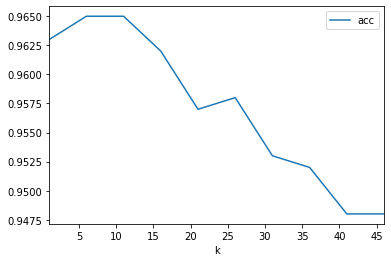

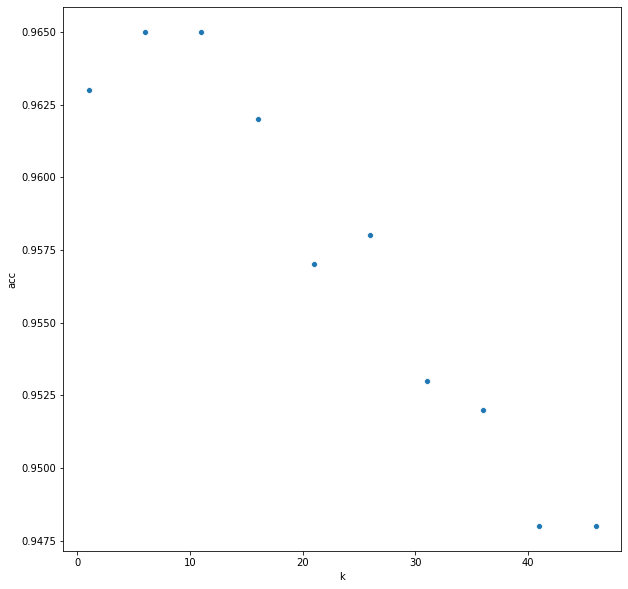

In [33]:
pruebaTestUnitario(20000)

### Experimento variando KFolds

In [9]:
splits = [15]

def experimentoFolds():
    data = pd.read_csv("../data/train.csv")
    df = pd.DataFrame(columns = ['Fold','Accuracy','Time','Kappa','F1 Score'])
    for split in tqdm(splits):
        kf = KFold(n_splits=split)

        for train, test in kf.split(data):
            dataTrain, labelTrain = data.loc[train, data.columns[1:]].values, data.loc[train, "label"].values.reshape(-1, 1)
            dataTest, labelTest = data.loc[test, data.columns[1:]].values, data.loc[test, "label"].values.reshape(-1, 1)

            pca = metnum.PCA(40)
            pca.fit(dataTrain)
            dataTrain = pca.transform(dataTrain)
            dataTest = pca.transform(dataTest)

            clf = metnum.KNNClassifier(5)
            clf.fit(dataTrain, labelTrain)

            t0 = time.clock()
            predTest = clf.predict(dataTest)
            t1 = time.clock() - t0 #segs

            acc = accuracy_score(labelTest, predTest)
            kappa = cohen_kappa_score(labelTest, predTest) # El orden da igual porque es simétrica.
            recall = recall_score(labelTest, predTest, average='weighted') # No es simetrico
            f1 = f1_score(labelTest, predTest, average='weighted')

            dfdata = {'Fold': split, 'Accuracy': acc, 'Time': t1, 'Kappa': kappa, 'F1 Score': f1}
            df = df.append(dfdata, ignore_index=True)

        
        df = df.groupby(['Fold']).mean().reset_index()
        pd.DataFrame(df).to_csv('results/expFold/data15.csv')
    return


In [10]:
experimentoFolds()

100%|██████████| 1/1 [04:24<00:00, 264.17s/it]


### Experimento distintas distancias KNN

In [3]:
def experimentoDistancias():
    data = pd.read_csv("../data/train.csv")
    df = pd.DataFrame(columns = ['Accuracy','Time','Kappa', 'Recall', 'F1 Score'])

    kf = KFold(n_splits=5)

    for train, test in kf.split(data):
        print('Nuevo fold')
        dataTrain, labelTrain = data.loc[train, data.columns[1:]].values, data.loc[train, "label"].values.reshape(-1, 1)
        dataTest, labelTest = data.loc[test, data.columns[1:]].values, data.loc[test, "label"].values.reshape(-1, 1)

        pca = metnum.PCA(40)
        pca.fit(dataTrain)
        dataTrain = pca.transform(dataTrain)
        dataTest = pca.transform(dataTest)
        
        clf = metnum.KNNClassifier(5)
        clf.fit(dataTrain, labelTrain)

        t0 = time.clock()
        predTest = clf.predict(dataTest)
        t1 = time.clock() - t0 #segs

        acc = accuracy_score(labelTest, predTest)
        kappa = cohen_kappa_score(labelTest, predTest) # El orden da igual porque es simétrica.
        recall = recall_score(labelTest, predTest, average='weighted') # No es simetrico
        f1 = f1_score(labelTest, predTest, average='weighted')

        dfdata = {'Accuracy': acc, 'Time': t1, 'Kappa': kappa, 'Recall': recall, 'F1 Score': f1}
        df = df.append(dfdata, ignore_index=True)

    df = df.mean().to_frame().T
    pd.DataFrame(df).to_csv('results/expDistancias/dataEuclidea2.csv')
    return


In [4]:
experimentoDistancias()

Nuevo fold
Nuevo fold
Nuevo fold
Nuevo fold
Nuevo fold


### Trash

In [120]:
dataPCA = pd.read_csv("results/exp1/PCA.csv")

dataPCA2 = dataPCA.loc[dataPCA['Fold'] == 2.0]
dataPCA5 = dataPCA.loc[dataPCA['Fold'] == 5.0]

dataNoPCA = pd.read_csv("results/exp1/noPCA.csv")

dataNoPCA2 = dataNoPCA.loc[dataNoPCA['Fold'] == 2.0]
dataNoPCA5 = dataNoPCA.loc[dataNoPCA['Fold'] == 5.0]

print('Mejores resultados usando PCA: \n')
dataPCA5['Time'].argmax()
print(dataPCA5.loc[298]) #Acc

print('\n Mejores resultados sin PCA: \n')
#dataNoPCA5['Time'].argmax()
print(dataNoPCA5.loc[11]) #Acc

dataPCA5 = dataPCA5.loc[[298]]
dataNoPCA5 = dataNoPCA5.loc[[11]]

dataNoPCA5 = dataNoPCA5[['Time','Accuracy','Kappa', 'F1 Score']]
dataPCA5 = dataPCA5[['Time','Accuracy','Kappa', 'F1 Score']]

dataNoPCA5.insert(2, "Metodo", "Sin PCA") 
dataPCA5.insert(2, "Metodo", "Con PCA") 

dfBar = pd.concat([dataNoPCA5, dataPCA5])
dfBar = dfBar[['Time','Accuracy','Kappa', 'F1 Score']].round(decimals = 3)
dfBar["Time"] = dfBar["Time"].div(1000)
dfBar["Time (segs)"] = dfBar["Time"]
dfBar = dfBar[['Metodo', 'Time (segs)','Accuracy','Kappa', 'F1 Score']]

print(dfBar.to_latex(index=False))
print(dfBar)

Mejores resultados usando PCA: 

Unnamed: 0      78.000000
Fold             5.000000
Alpha           40.000000
k                5.000000
Accuracy         0.973167
Time          8118.625200
Kappa            0.970173
Recall           0.973167
F1 Score         0.973130
Name: 298, dtype: float64

 Mejores resultados sin PCA: 

Unnamed: 0         0.000000
Fold               5.000000
k                  1.000000
Accuracy           0.966167
Time          136545.301800
Kappa              0.962391
Recall             0.966167
F1 Score           0.966124
Name: 11, dtype: float64


/home/schuster/.virtualenvs/metodos/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  if sys.path[0] == '':


KeyError: "['Metodo'] not in index"